# Default Setup

In [0]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Glove Stuff
from scipy import spatial
from sklearn.manifold import TSNE

# Use SS3 Repo
!rm -rf pyss3
!git clone https://github.com/sergioburdisso/pyss3.git

from pyss3.pyss3.__init__ import SS3
from pyss3.pyss3.util import Dataset, Evaluation, span

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data'
multi_label_dir = '/SB1_Train_Multilabel'

Cloning into 'pyss3'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 1895 (delta 55), reused 73 (delta 37), pack-reused 1793
Receiving objects: 100% (1895/1895), 49.06 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (1225/1225), done.
Mounted at /content/drive


## Load Data

In [0]:
attribute = True
if attribute:
  text, labels = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir + '/attribute-text.txt', path_root + data_root + multi_label_dir + '/attribute-labels.txt', sep_label=';')
  X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.3)
else:
  text, labels = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir + '/entity-text.txt', path_root + data_root + multi_label_dir + '/entity-labels.txt', sep_label=';')
  X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.3)

100%|██████████| 3748/3748 [00:00<00:00, 662519.02it/s]


## Load Glove Embeddings

In [0]:
# https://gist.github.com/EvolvedSquid/03b002ae0a623c2d2ecab378255b7aaa#file-get_closest_embeddings-py
embeddings_dict = {}
with open("/content/drive/My Drive/NLP Lab/data/glove.840B.300d.txt", 'r', encoding="utf-8") as files:
  for line in files:
    values = line.split()
    word = values[0]
    try:
      vector = np.asarray(values[1:], "float32")
      if len(vector) == 300: ## Unfortunately there are some entries not correct
        embeddings_dict[word] = vector
    except:
      print("Failed:", word, values[1])

Failed: . .
Failed: at name@domain.com
Failed: . .
Failed: to name@domain.com
Failed: . .
Failed: . .
Failed: email name@domain.com
Failed: or name@domain.com
Failed: contact name@domain.com


KeyboardInterrupt: ignored

## Get NLTK Stuff ready

In [0]:
!pip3 install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import download

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenize and Filter Stopwords

In [0]:
def tokenize_samples(samples):
  return list(map(word_tokenize, samples))

def filter_stop_words(token_samples):
  return list(map(lambda x: [w for w in x if w not in stop_words], token_samples))

X_train_tok = tokenize_samples(X_train)
X_train_filtered = filter_stop_words(X_train_tok)

token_test = tokenize_samples(["This is a sample sentence, showing off the stop words filtration."])
filter_test = filter_stop_words(token_test)
filter_test

[['This',
  'sample',
  'sentence',
  ',',
  'showing',
  'stop',
  'words',
  'filtration',
  '.']]

## Enhance with words found by glove embedding

In [0]:
def find_closest_embeddings_word(embedding, num_words):
  return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))[1:num_words+1]

def enhance_with_glove_stupid(filtered_words, num_words):
  for sample in filtered_words:
    for word in sample:
      closest = find_closest_embeddings_word(embeddings_dict[word], num_words)
    return word, closest


def enhance_with_glove(filtered_words, num_words):
  enhanced_words = []
  for sample in filtered_words:
    print("Before:", sample)
    closest_words = [find_closest_embeddings_word(embeddings_dict[word], num_words) for word in sample]
    for closest in closest_words:
      sample.extend(closest)
    enhanced_words.append(sample)
    print("After:", sample)
  return enhanced_words

#enhance_with_glove([['This']], 2)

## Definitely a nice try, but runtime complexity is definitely to high
So lets try out something different. We will first use a smaller glove embedding.

In [0]:
embeddings_dict_small = {}
with open("/content/drive/My Drive/NLP Lab/data/glove.6B.50d.txt", 'r', encoding="utf-8") as files:
  for line in files:
    values = line.split()
    word = values[0]
    try:
      vector = np.asarray(values[1:], "float32")
      if len(vector) == 50: ## Unfortunately there are some entries not correct
        embeddings_dict_small[word] = vector
    except:
      print("Failed:", word, values[1])

In [0]:
def find_closest_embeddings_word_small(embedding, num_words):
  print("Embedding")
  return sorted(embeddings_dict_small.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict_small[word], embedding))[1:num_words+1]

def enhance_with_glove_small(filtered_words, num_words):
  enhanced_words = []
  for sample in filtered_words:
    print("Before:", sample)
    closest_words = [find_closest_embeddings_word_small(embeddings_dict_small[word], num_words) for word in sample]
    for closest in closest_words:
      sample.extend(closest)
    enhanced_words.append(sample)
    print("After:", sample)
  return enhanced_words

enhance_with_glove_small([['Soccer']], 2)

Before: ['Soccer']


KeyError: ignored

## As one can see, that doesn't make sense, since a lot of words are not in there. 
So next approach is to go through the vocabulary and calculate these words for each vocab in there.

In [0]:
vocabulary = pd.read_csv(path_root + data_root + '/vocabulary-attribute/vocab_cv.csv')

In [0]:
import time

closest_mapping = {}
counter = 0
for word in vocabulary['term']:
  print(len(vocabulary['term']) - counter, " words to go")
  start = time.time()
  closest = find_closest_embeddings_word(embeddings_dict[word], 10)
  closest_mapping[word] = closest
  end = time.time()
  print("Time for finding word:", end-start)
  break

1672  words to go
Time for finding word: 7.819216966629028


## Calculating the nearest words costs ~30 seconds per word
This results in 1700*30/3600 = ~14h. Definitely to long for a colab notebook.
We will build a parallelized script to do so in the background on a different server. Using this approach we can reduce the time to 1.5h.

In [0]:
# Load Nearest words dict
import json
with open(path_root + data_root + '/vocabulary-attribute/final_mapping.json') as file:
  closest_words = json.load(file)

## Next we're going to enhance the actual dataset before training/testing


In [0]:
from functools import reduce

def enhance(dset):
  tok_dset = tokenize_samples(dset)
  fil_dset = filter_stop_words(tok_dset)
  dset_enhanced = []

  failed_counter = 0
  worked_counter = 0

  for index in range(len(dset)):
    sample_enhanced = [dset[index]]
    sample = fil_dset[index]
    for word in sample:
      try:
        sample_enhanced.extend(closest_words[word])
        worked_counter += 1
      except:
        failed_counter += 1
    sample_enhanced = reduce(lambda a,b: a+ " " + b, sample_enhanced)
    dset_enhanced.append(sample_enhanced)

  print("Worked:", worked_counter, " Failed:", failed_counter)
  return dset_enhanced

X_train_enhanced = enhance(X_train)
X_val_enhanced = enhance(X_val)

Worked: 10600  Failed: 13628
Worked: 4600  Failed: 5783




Training:   0%|          | 0/2623 [00:00<?, ?it/s]

Training:   6%|▋         | 168/2623 [00:00<00:01, 1679.77it/s]

Training:  15%|█▌        | 403/2623 [00:00<00:01, 1834.89it/s]

Training:  23%|██▎       | 603/2623 [00:00<00:01, 1874.23it/s]

Training:  28%|██▊       | 736/2623 [00:00<00:02, 788.20it/s] 

Training:  32%|███▏      | 840/2623 [00:00<00:02, 691.96it/s]

Training:  35%|███▌      | 929/2623 [00:01<00:02, 572.90it/s]

Training:  38%|███▊      | 1004/2623 [00:01<00:02, 543.27it/s]

Training:  47%|████▋     | 1226/2623 [00:01<00:01, 701.47it/s]

Training:  56%|█████▌    | 1459/2623 [00:01<00:01, 887.28it/s]

Training:  63%|██████▎   | 1646/2623 [00:01<00:01, 828.93it/s]

Training:  72%|███████▏  | 1885/2623 [00:01<00:00, 1030.87it/s]

Training:  78%|███████▊  | 2045/2623 [00:02<00:00, 895.28it/s] 

Training:  83%|████████▎ | 2178/2623 [00:02<00:00, 811.41it/s]

Training:  87%|████████▋ | 2291/2623 [00:02<00:00, 369.08it/s]

Training: 100%|██████████| 2623/2623 [00:03<00:00,


                       precision    recall  f1-score   support

              general       0.67      0.83      0.74       529
            usability       0.26      0.84      0.40        76
operation_performance       0.43      0.86      0.57       139
              quality       0.55      0.79      0.64       364
          portability       0.12      0.93      0.21        14
      design_features       0.30      0.91      0.45       106
        style_options       0.17      0.80      0.28        45
                price       0.27      0.90      0.42        52
        miscellaneous       0.20      0.69      0.31        75
               prices       0.17      0.89      0.29        45
         connectivity       0.24      0.50      0.32        22

            micro avg       0.39      0.82      0.53      1467
            macro avg       0.31      0.81      0.42      1467
         weighted avg       0.49      0.82      0.59      1467
          samples avg       0.47      0.84      0.56

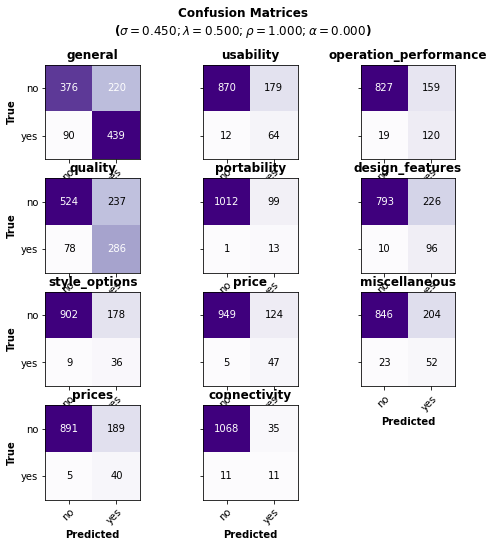

0.17074747474747476

In [0]:
clf = SS3()
clf.fit(X_train_enhanced, y_train)
Evaluation.test(clf, X_val_enhanced, y_val)

In [0]:
s_l = span(0, 1, 10)
l_l = span(0, 5, 10)
p_l = span(0, 5, 10)
a_l = span(0, 1, 10)
best_s, best_l, best_p, best_a = Evaluation.grid_search(clf, X_train, y_train, s=s_l, l=l_l, p=p_l, a=a_l, n_grams=6)

Streaming output truncated to the last 5000 lines.
Grid search:  72%|███████▏  | 7224/10000 [1:44:51<1:03:52,  1.38s/it]

Grid search:  72%|███████▏  | 7225/10000 [1:44:53<1:04:47,  1.40s/it]

Grid search:  72%|███████▏  | 7226/10000 [1:44:54<1:05:30,  1.42s/it]

Grid search:  72%|███████▏  | 7227/10000 [1:44:56<1:06:04,  1.43s/it]

Grid search:  72%|███████▏  | 7228/10000 [1:44:57<1:06:08,  1.43s/it]

Grid search:  72%|███████▏  | 7229/10000 [1:44:59<1:06:09,  1.43s/it]

Grid search:  72%|███████▏  | 7230/10000 [1:45:00<1:06:07,  1.43s/it]

Grid search:  72%|███████▏  | 7232/10000 [1:45:02<1:00:07,  1.30s/it]

Grid search:  72%|███████▏  | 7233/10000 [1:45:04<1:02:40,  1.36s/it]

Grid search:  72%|███████▏  | 7234/10000 [1:45:05<1:03:41,  1.38s/it]

Grid search:  72%|███████▏  | 7235/10000 [1:45:06<1:04:04,  1.39s/it]

Grid search:  72%|███████▏  | 7236/10000 [1:45:08<1:06:10,  1.44s/it]

Grid search:  72%|███████▏  | 7237/10000 [1:45:09<1:06:05,  1.44s/it]

Grid search:  72%|███████▏



Caching documents:   0%|          | 0/1125 [00:00<?, ?it/s]

Caching documents:  25%|██▍       | 277/1125 [00:00<00:00, 1264.80it/s]

Caching documents:  34%|███▍      | 388/1125 [00:00<00:00, 940.97it/s] 

Caching documents:  62%|██████▏   | 701/1125 [00:00<00:00, 1040.80it/s]

                                                                       

Classification: 100%|██████████| 1125/1125 [00:00<00:00, 14954.64it/s]



                       precision    recall  f1-score   support

              general       0.66      0.81      0.73       529
            usability       0.40      0.72      0.51        76
operation_performance       0.65      0.70      0.67       139
              quality       0.69      0.72      0.70       364
          portability       0.48      0.71      0.57        14
      design_features       0.48      0.77      0.59       106
        style_options       0.38      0.62      0.47        45
                price       0.34      0.83      0.48        52
        miscellaneous       0.47      0.39      0.42        75
               prices       0.21      0.80      0.33        45
         connectivity       0.48      0.45      0.47        22

            micro avg       0.55      0.74      0.63      1467
            macro avg       0.47      0.69      0.54      1467
         weighted avg       0.59      0.74      0.65      1467
          samples avg       0.62      0.76      0.65

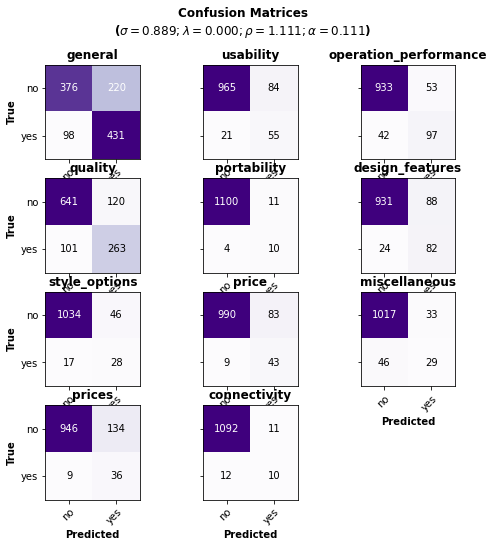

0.54184454803254

In [0]:
clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
Evaluation.test(clf, X_val_enhanced, y_val, metric='f1-score')

In [0]:
print("Best s:", best_s, " Best l:", best_l, " Best p:", best_p, " Best a:", best_a)

Best s: 0.8889  Best l: 0.0  Best p: 1.1111  Best a: 0.1111




Classification: 100%|██████████| 1125/1125 [00:00<00:00, 15387.75it/s]



                       precision    recall  f1-score   support

              general       0.67      0.82      0.74       529
            usability       0.40      0.72      0.52        76
operation_performance       0.66      0.68      0.67       139
              quality       0.68      0.73      0.71       364
          portability       0.48      0.71      0.57        14
      design_features       0.48      0.77      0.59       106
        style_options       0.33      0.62      0.43        45
                price       0.35      0.83      0.49        52
        miscellaneous       0.47      0.39      0.42        75
               prices       0.21      0.80      0.33        45
         connectivity       0.48      0.45      0.47        22

            micro avg       0.55      0.74      0.63      1467
            macro avg       0.47      0.69      0.54      1467
         weighted avg       0.59      0.74      0.65      1467
          samples avg       0.62      0.76      0.65

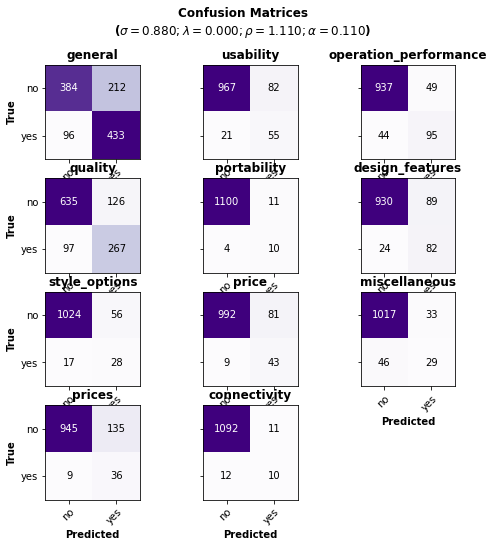

0.5399012451456714

In [0]:
clf.set_hyperparameters(s=0.88, l=0, p=1.11, a=0.11)
Evaluation.test(clf, X_val_enhanced, y_val, metric='f1-score')